In [1]:
import requests
import re
import os
import pandas as pd
import numpy as np
import json

# Librerias para gráficos
import folium
from folium import plugins
import ipywidgets
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import squarify 
import geocoder

# Claves de acceso para consultas API
key = '?key=3dd4ba3157b4401eabba298e67e55b25'
keyNcaa = '?key=c6c9638e211c4b55acadbd15f8194f1e'

# URL del json que contiene los datos georreferenciales de los estados de USA
state_geo = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'

In [2]:
# URL CONSULTA DE JUGADORES ACTIVOS
url_players = 'https://fly.sportsdata.io/v3/nfl/scores/json/Players'
getURL = url_players + key

# Obtener datos de la API
response = requests.get(getURL)

# Genera el Data frame con la información
playersTemp = pd.DataFrame(response.json())

# Agregar año actual
playersTemp['CurrentYear'] = 2021

# Corregir años de experiencia
playersTemp['Experience'] = playersTemp['CurrentYear'] - playersTemp['CollegeDraftYear']

# Eliminar los ZEROS y guiones del campo COLLEGE
playersTemp.loc[playersTemp['College'].isin(['-','0']),'College'] = ''

# Eliminar los valores NAN
playersTemp.fillna(0, inplace=True)

# Jugadores reclutados desde el 2015
dfCollegeRecruitment = playersTemp[(playersTemp['CollegeDraftYear'] >=2015)&(~playersTemp.College.isin(['None','','0']))].groupby('College').agg({'PlayerID':'count'}).reset_index()


In [3]:
# Leer archivo JSON de puntos georreferenciales de estados de USA
with open('../output/geo_ref_usa.json') as json_file:
    state_geo_usa = json.load(json_file)
    

In [4]:
# Se genera el mapa de calor Universidades
mapa = folium.Map(location=[40, -95], zoom_start=4, width=700,height = 450)
folium.Choropleth(
    geo_data=state_geo_usa,
    name="choropleth",
    data=dfCollegeRecruitment,
    columns=["College", "PlayerID"],
    key_on="feature.properties.name",
    fill_color="YlGnBu",  #OrRd, PuBuGn, YlGnBu, YlOrBr
    fill_opacity=0.7,
    line_opacity=.1,
    legend_name="Reclutamiento por universidad desde 2015",
    reset = True
).add_to(mapa)
folium.LayerControl().add_to(mapa)
mapa
mapa.save('../output/mapaCollege.html')

In [5]:
# Temporadas promedio por posición
dfSeasonMeanbyPos = playersTemp[(playersTemp['Experience'] > 0)&(playersTemp['Active'] == False)].groupby(['Position','PositionCategory']).agg({'Experience':'mean'}).reset_index()


In [6]:
# salvar los datos limpios para usarlos en Power BI
player_list = playersTemp[['PlayerID', 'Team', 'Number', 'FirstName', 'LastName', 'Position', 'Status', 'Height', 'Weight', 'BirthDate', 'College', 'Experience','FantasyPosition', 'Active', 'PositionCategory', 'Name', 'Age','ExperienceString', 'BirthDateString', 'ShortName', 'CurrentTeam', 'CollegeDraftTeam', 'CollegeDraftYear', 'CollegeDraftRound', 'CollegeDraftPick', 'IsUndraftedFreeAgent', 'HeightFeet', 'HeightInches']]

In [7]:
# player_list.head(3)

In [8]:
# Leer api con las estadísticas de la última temporada regular
urlPlayerSeasonStats = 'https://fly.sportsdata.io/v3/nfl/stats/json/PlayerSeasonStats/'
season  = '2020REG'
getURLPlayerSeasonStats = urlPlayerSeasonStats + season + key
respons2020SeasonTemp = requests.get(getURLPlayerSeasonStats)

# respons2020SeasonTemp
df2020SeasonTemp = pd.DataFrame(respons2020SeasonTemp.json())

# Recuperar solo las columnas utiles para estas mediciones
df2020Season = df2020SeasonTemp[['PlayerID','SeasonType','Season','Team','Number','Name','Position','PositionCategory','Activated','Played','Started','OffensiveSnapsPlayed','DefensiveSnapsPlayed','SpecialTeamsSnapsPlayed']]

# Obtener promedio de jugadas por temporada
dfPlaysbyPosition = df2020Season[df2020Season['Played'] ==16].groupby(['Position'])['OffensiveSnapsPlayed','DefensiveSnapsPlayed','SpecialTeamsSnapsPlayed'].mean().reset_index()

# Unir dos data frames para calcular promedio de temporadas y promedio de juagas 
dfPlaysbyPositionAndAvgSeason = pd.merge(dfPlaysbyPosition, dfSeasonMeanbyPos, on='Position')

# Agregamos columna con el total de jugadas por temporada
dfPlaysbyPositionAndAvgSeason['TotalPlays'] = np.round(dfPlaysbyPositionAndAvgSeason['OffensiveSnapsPlayed'] \
                                            + dfPlaysbyPositionAndAvgSeason['DefensiveSnapsPlayed']  \
                                            + dfPlaysbyPositionAndAvgSeason['SpecialTeamsSnapsPlayed'], decimals= 1)

# Redondeando los decimales en el promedio de experiencia
dfPlaysbyPositionAndAvgSeason['Experience'] = np.round(dfPlaysbyPositionAndAvgSeason['Experience'], decimals=1)


<ipython-input-8-7a48791c28cb>:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfPlaysbyPosition = df2020Season[df2020Season['Played'] ==16].groupby(['Position'])['OffensiveSnapsPlayed','DefensiveSnapsPlayed','SpecialTeamsSnapsPlayed'].mean().reset_index()


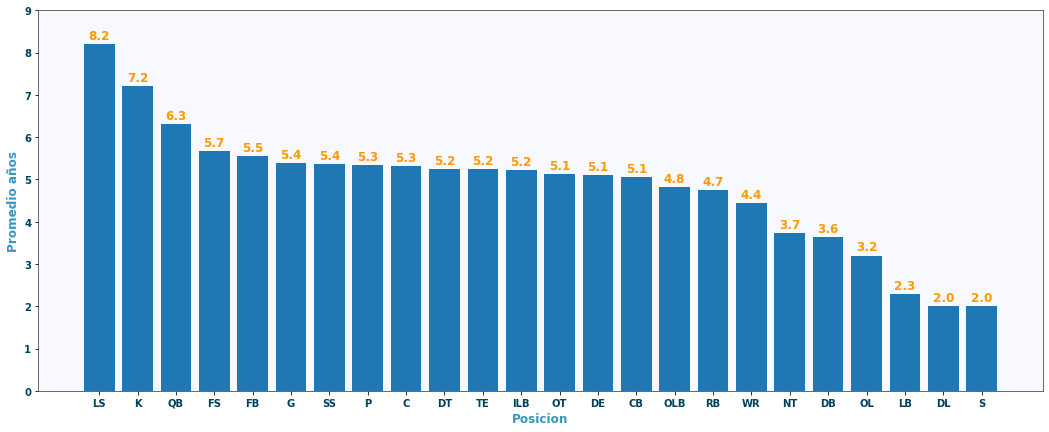

In [9]:
# Graficas sugeridas para la presentación

# Grafica de barras para mostrar el promedio de años jugados en la NFL por posición
plt.figure(figsize=(18,7))
plt.rcParams['axes.facecolor'] = '#F8F9FE'
plt.rcParams['axes.edgecolor'] = '#464646'
# plt.rcParams['ytick.color'] = '#01415C'
plt.yticks(weight = 'bold', color= '#01415C')
plt.xticks(weight = 'bold', color= '#01415C')
setAxisLabels = {'color':'#3796BF', 'weight':'semibold', 'fontsize':12}
plt.xlabel('Posicion',fontdict=setAxisLabels)
plt.ylabel('Promedio años',fontdict=setAxisLabels)
plt.ylim(0,9)
plt.bar(data= dfSeasonMeanbyPos.sort_values('Experience', ascending=False), x='Position', height='Experience')

for line in range(0,dfSeasonMeanbyPos.shape[0]):
    plt.text(dfSeasonMeanbyPos.Position[line], dfSeasonMeanbyPos.Experience[line]+0.2
             , np.round(dfSeasonMeanbyPos.Experience[line], decimals=1), horizontalalignment='center'
          , verticalalignment = 'center', fontsize =12, color='#FF9901', weight='semibold') 
plt.show()


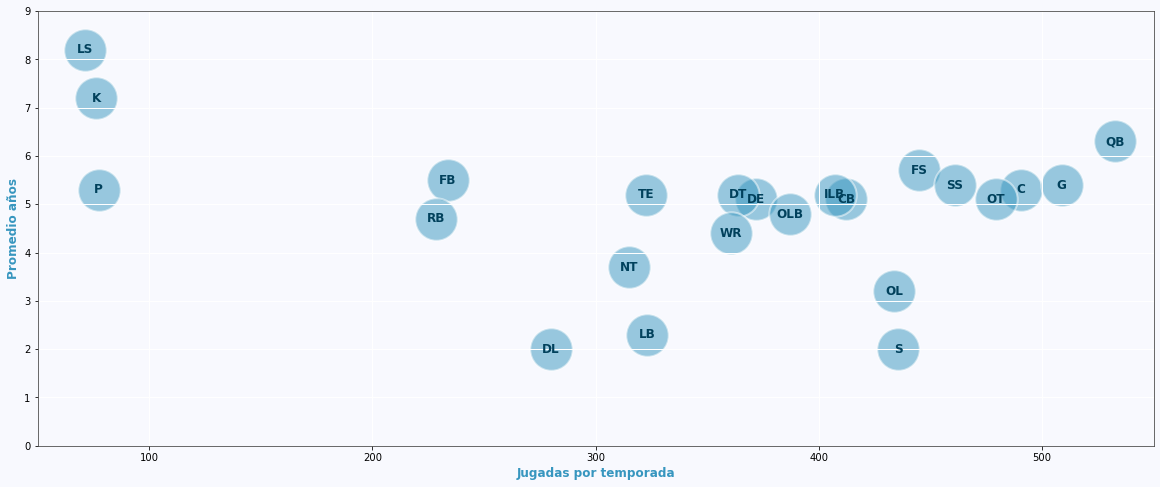

In [10]:
plt.figure(figsize=(20,8), facecolor='#F8F9FE')
plt.grid(b=True, color = 'w', linestyle = '-', linewidth= 1)
plt.rcParams['axes.facecolor'] = '#F8F9FE'
plt.rcParams['axes.edgecolor'] = '#464646'
plt.rcParams['ytick.color'] = '#01415C'
plt.rcParams['xtick.color'] = '#01415C'
plt.scatter(data=dfPlaysbyPositionAndAvgSeason, x = 'TotalPlays', y = 'Experience', s= 1800, cmap="Accent", color = '#3796BF', alpha=0.5
            , edgecolors='white', linewidth=2)
for line in range(0,dfPlaysbyPositionAndAvgSeason.shape[0]):
  plt.text(dfPlaysbyPositionAndAvgSeason.TotalPlays[line], dfPlaysbyPositionAndAvgSeason.Experience[line], dfPlaysbyPositionAndAvgSeason.Position[line], horizontalalignment='center'
          , verticalalignment = 'center', fontsize =12, color='#01415C', weight='semibold') #, weight='semibold'
setAxisLabels = {'color':'#3796BF', 'weight':'semibold', 'fontsize':12}
plt.xlabel('Jugadas por temporada',fontdict=setAxisLabels)
plt.xlim(50, 550)
plt.ylabel('Promedio años',fontdict=setAxisLabels)
plt.ylim(0,9)
# plt.title('Avg. plays by season vs Avg. seasons', fontsize = 18, weight='semibold', color ='#464646')
plt.show()

In [11]:
# Grafica de los seleccionados en 2015 y que ahora están inactivos, años de juego y estatus
dfPlayersInactives = playersTemp[(playersTemp.CollegeDraftYear >= 2015) & (~playersTemp.Status.isin(['Active', 'Inactive']))][['Position','Experience','Status']]
# dfPlayersInactives

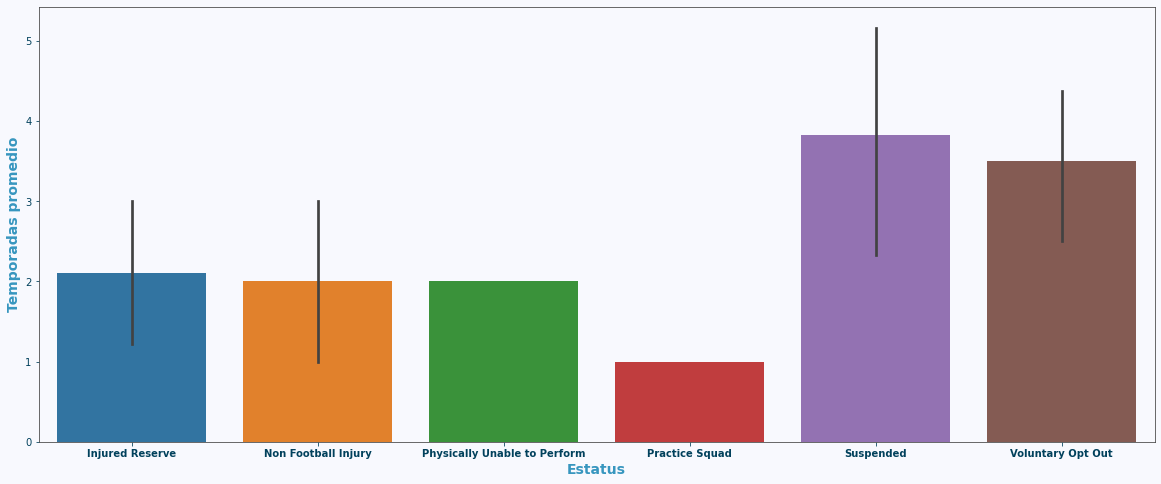

In [12]:
plt.figure(figsize=(20,8), facecolor='#F8F9FE')
sns.set_context()
ax = sns.barplot(data = dfPlayersInactives, x = dfPlayersInactives['Status'].sort_values(),
                 y = dfPlayersInactives['Experience'])

setAxisLabels = {'color':'#3796BF', 'weight':'semibold', 'fontsize':14}
plt.xlabel('Estatus',fontdict=setAxisLabels)
plt.ylabel('Temporadas promedio',fontdict=setAxisLabels)
# ax.set(xlabel='Estatus', ylabel='Años Experiencia')
ax.set_xticklabels(ax.get_xticklabels(), color = '#01415C', weight = 'bold');

In [85]:
dfAvgExperiencebyRound = playersTemp[(playersTemp.CollegeDraftYear >= 2000)&(playersTemp['CollegeDraftRound'] != 48)& (playersTemp['Active'] == False)][['Position','Experience','CollegeDraftRound','IsUndraftedFreeAgent']]
dfAvgExperiencebyRound

,Position,Experience,CollegeDraftRound,IsUndraftedFreeAgent
1831,QB,3.0,0.0,True
1863,P,2.0,0.0,True
1897,C,3.0,0.0,True
1898,WR,3.0,0.0,True
1916,FS,3.0,0.0,True
...,...,...,...,...
4448,DE,5.0,5.0,False
4449,ILB,5.0,5.0,False
4450,WR,5.0,5.0,False
4451,RB,5.0,5.0,False


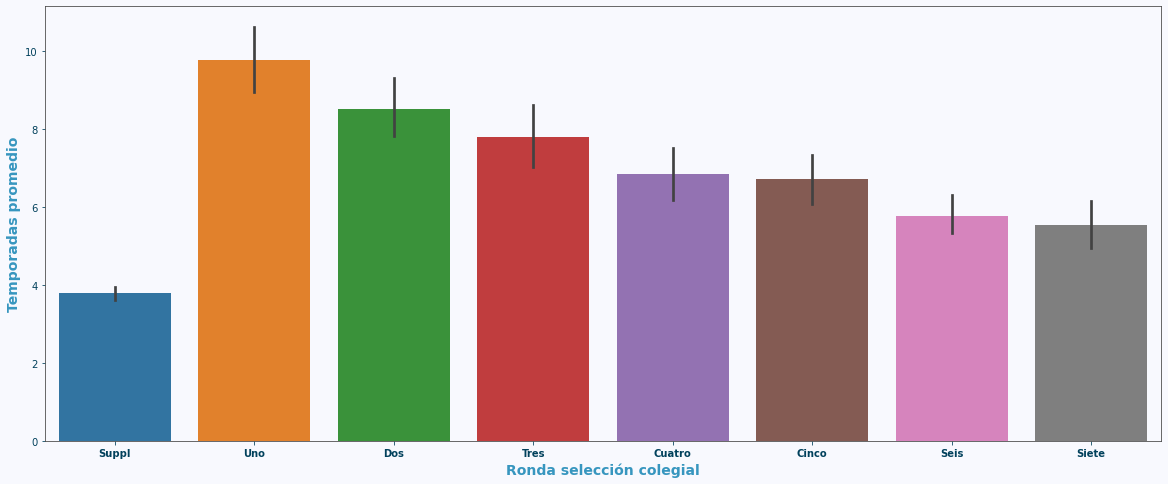

In [88]:
plt.figure(figsize=(20,8), facecolor='#F8F9FE')
sns.set_context()
ax = sns.barplot(data = dfAvgExperiencebyRound, 
                 x = dfAvgExperiencebyRound['CollegeDraftRound'],
                 y = dfAvgExperiencebyRound['Experience'].sort_values(ascending=False))

setAxisLabels = {'color':'#3796BF', 'weight':'semibold', 'fontsize':14}
plt.xlabel('Ronda selección colegial',fontdict=setAxisLabels)
plt.ylabel('Temporadas promedio',fontdict=setAxisLabels)
ax.set_xticklabels(['Suppl','Uno','Dos','Tres','Cuatro','Cinco','Seis','Siete'], color = '#01415C', weight = 'bold');

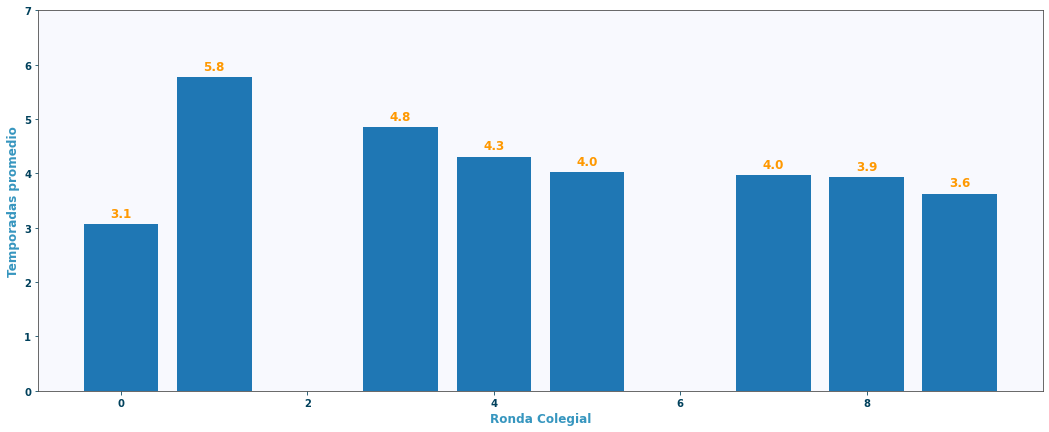

In [82]:
dfAvgbyRound = dfAvgExperiencebyRound.groupby('CollegeDraftRound').mean('Experience').reset_index()
# dfAvgbyRound
plt.figure(figsize=(18,7))
plt.rcParams['axes.facecolor'] = '#F8F9FE'
plt.rcParams['axes.edgecolor'] = '#464646'
# plt.rcParams['ytick.color'] = '#01415C'
plt.yticks(weight = 'bold', color= '#01415C')
plt.xticks(weight = 'bold', color= '#01415C')
setAxisLabels = {'color':'#3796BF', 'weight':'semibold', 'fontsize':12}
plt.xlabel('Ronda Colegial',fontdict=setAxisLabels)
plt.ylabel('Temporadas promedio',fontdict=setAxisLabels)
plt.ylim(0,7)
plt.bar(data= dfAvgbyRound.sort_values('CollegeDraftRound', ascending=False), x='CollegeDraftRound', height='Experience')

for line in range(0,dfAvgbyRound.shape[0]):
    plt.text(dfAvgbyRound.CollegeDraftRound[line], dfAvgbyRound.Experience[line]+0.2
             , np.round(dfAvgbyRound.Experience[line], decimals=1), horizontalalignment='center'
          , verticalalignment = 'center', fontsize =12, color='#FF9901', weight='semibold') 
plt.show()

In [13]:
player_list.to_csv('../output/nfl_player_list_02.csv', index = False)
df2020Season.to_csv('../output/nfl_2020_stats_02.csv', index = False)